In [3]:
import numpy as np
import pandas as pd
import scipy.io as scio
import matplotlib.pyplot as plt
import warnings
import functools
from mpl_toolkits.mplot3d import Axes3D
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
import scipy.io
import scipy.linalg
warnings.filterwarnings('ignore')

[[4 6 4 0]
 [4 7 5 2]
 [6 4 7 8]
 [1 5 0 6]]


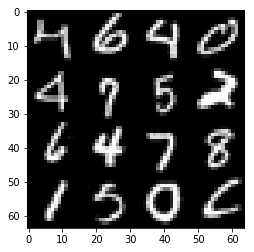

[[0 0 9 3]
 [0 0 0 7]
 [1 9 8 7]
 [0 9 9 8]]


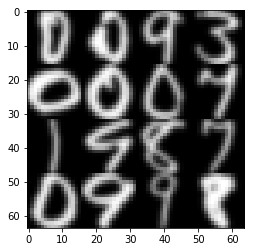

In [4]:
usps = scio.loadmat('usps.mat.bin')
mnist = scio.loadmat('mnist.mat.bin')

'''Visualization'''

## images in MNIST
mnist_rdm = np.random.randint(2000, size=16)
mnist_labels = mnist['Y'][mnist_rdm].reshape(4,4).T - 1
mnist_ims = mnist['X'][:,mnist_rdm].T
mnist_ims = np.array([im.reshape(16,16) for im in mnist_ims])
mnist_ims = functools.reduce(lambda x, y : np.concatenate((x, y),axis=1), np.array([mnist_ims[i*4:(i+1)*4].reshape(4*16,-1) for i in range(4)]))
print(mnist_labels)
plt.imshow(mnist_ims, cmap='gray')
plt.show()

## images in USPS
usps_rdm = np.random.randint(1800, size=16)
usps_labels = usps['Y'][usps_rdm].reshape(4,4).T - 1
usps_ims = usps['X'][:,usps_rdm].T
usps_ims = np.array([im.reshape(16,16) for im in usps_ims])
usps_ims = functools.reduce(lambda x, y : np.concatenate((x, y),axis=1), np.array([usps_ims[i*4:(i+1)*4].reshape(4*16,-1) for i in range(4)]))
print(usps_labels)
plt.imshow(usps_ims, cmap='gray')
plt.show()

In [5]:
'''
Kernels
X: m x n
m: num of features
n: num of instances
'''
def kernel(kernel_type, X, gamma = 1):
    if kernel_type == 'original':
        K = X
    elif kernel_type == 'linear':
        K = np.dot(X.T, X)
    elif kernel_type == 'rbf':
        D = np.sum(X.T**2, axis=1).reshape(X.shape[1],-1).dot(np.ones((1,X.shape[1]))) + \
            np.ones((X.shape[1], 1)).dot(np.sum(X.T**2, axis=1).reshape(-1,X.shape[1])) - 2*X.T.dot(X)
        K = np.exp(-gamma * D)
    return K

In [6]:
def JDA(source, target, lamda, gamma, kernel_type='rbf', iterations=10, Y_pseudo=None):
    X_source, Y_source = source['X'], source['Y']
    X_target, Y_target = target['X'], target['Y']
    ns, nt = len(Y_source), len(Y_target)
    n = ns + nt
    '''concatenate the source and target data'''
    X = np.concatenate((X_source, X_target), axis = 1)
    '''normlization is important, the acc is very low without this step'''
    X /= np.linalg.norm(X, axis=0)
    '''construct the matrix H'''
    H = np.eye(n) - (1/n) * np.ones((n,n))
    '''construct the matrix M0'''
    e0 = np.concatenate((np.ones((ns,1))/ns, -np.ones((nt,1))/nt), axis=0)
    M0 = e0.dot(e0.T) 
    
    if Y_pseudo is not None:
        C = len(np.unique(Y_source))
        for i in range(iterations):
            print('    iteration:',i+1, ' ', end='')
            N = 0
            for c in range(1, C+1):
                e = np.zeros((n, 1))
                e[np.where(Y_source==c)] = 1 / len(Y_source[np.where(Y_source==c)])
                e[np.where(Y_pseudo==c)[0] + ns] = -1 / len(Y_pseudo[np.where(Y_pseudo==c)])
                N += e.dot(e.T)

            M = M0 + N
            M /= np.linalg.norm(M,'fro')
            n_eye = X.shape[0] if kernel_type == 'original' else n
            K = kernel(kernel_type, X, gamma)
            eig_vals, eig_vecs = np.linalg.eig(np.linalg.pinv(np.linalg.multi_dot([K, H, K.T])).dot(np.linalg.multi_dot([K, M, K.T]) + lamda * np.eye(n_eye)))
            ind = np.argsort(eig_vals)
            A = eig_vecs[:,ind[:100]]
            Z = A.T.dot(K)
            Z /= np.linalg.norm(Z, axis = 0)
            
            X_source_JDA, X_target_JDA = Z[:,:ns], Z[:,ns:]
            
            pseudo = KNeighborsClassifier(n_neighbors=1)
            pseudo.fit(X_source_JDA.T, Y_source.flatten())
            Y_pseudo = pseudo.predict(X_target_JDA.T)
            pseudo_acc = sklearn.metrics.accuracy_score(Y_target.flatten(), Y_pseudo)
            print('acc:',pseudo_acc)
            
    return X_source_JDA, X_target_JDA
    
    

In [ ]:
### '''两个领域，分别是mnist, usps. 可以在增加其他数据集，构造多个领域'''
'''各个领域分别作为源领域和目标领域，'''
domain_names = ['mnist', 'usps']
domains = [mnist, usps]
for i in range(len(domains)):
    for j in range(len(domains)):
        if i != j:
            print('\n from', domain_names[i], 'to', domain_names[j])
            
            source, target = domains[i], domains[j]
            baseline = KNeighborsClassifier(n_neighbors=1)
            baseline.fit(source['X'].T, source['Y'].flatten())
            Y_pseudo_target = baseline.predict(target['X'].T)
            baseline_acc = sklearn.metrics.accuracy_score(target['Y'].flatten(), Y_pseudo_target)
            print('    acc of baseline 1-NN:', baseline_acc)
            
            X_JDA_source, X_JDA_target = JDA(source, target, lamda=1, gamma=1, kernel_type='rbf', iterations=5, Y_pseudo=Y_pseudo_target)
            jda = KNeighborsClassifier(n_neighbors=1)
            jda.fit(X_JDA_source.T, source['Y'].flatten())
            Y_pseudo_target = jda.predict(X_JDA_target.T)
            jda_acc = sklearn.metrics.accuracy_score(target['Y'].flatten(), Y_pseudo_target)
            print('    acc of jda:', jda_acc)
            
#             fig = plt.figure()
#             ax = fig.add_subplot(111, projection='3d')
#             plt.scatter(X_JDA_source[0,:], X_JDA_source[1,:], X_JDA_source[2,:], c=source['Y'].squeeze())
#             plt.show()
            
#             fig = plt.figure()
#             ax = fig.add_subplot(111, projection='3d')
#             ax.scatter(X_JDA_target[0,:], X_JDA_target[1,:], X_JDA_target[2,:], c=target['Y'].squeeze())
#             plt.show()
            
            


 from mnist to usps
    acc of baseline 1-NN: 0.6444444444444445
    iteration: 1  